In [1]:
from ray.rllib.offline.json_reader import JsonReader
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
input_reader = JsonReader("logs/APPO/RE3")

2022-12-31 14:17:31,383	WARNING json_reader.py:146 -- Treating input directory as glob patterns: ['/tf/Cage/Notebooks/logs/APPO/RE3/*.json', '/tf/Cage/Notebooks/logs/APPO/RE3/*.zip']


In [3]:
sequence_length=3
num_episodes = 10000
windows_per_episode = 100-sequence_length
state_len = 52
num_action = 1
encoding_len = state_len + num_action
state_to_index = {}
index_to_state = {}
state_index = 0

data_points = num_episodes * windows_per_episode

X = np.zeros((data_points,sequence_length,encoding_len))
Y_List = []

index = 0
for e in range(num_episodes):
    data = input_reader.next()
    data['obs'].shape
    for i in range(0, windows_per_episode):
        if not data['obs'][i+1].tobytes() in state_to_index:
            state_to_index[data['obs'][i+1].tobytes()] = state_index
            index_to_state[state_index] = data['obs'][i+1].tobytes()
            state_index += 1
        ns = state_to_index[data['obs'][i+1].tobytes()]
        if i < sequence_length:
            s = np.zeros((sequence_length, encoding_len))
            for k in range(0,i):
                s[k,:] = np.concatenate([data['obs'][k], np.zeros(num_action)])
        else:
            #vec = np.zeros((sequence_length, num_action))
            #vec[np.arange(sequence_length),data['actions'][i-sequence_length:i]] = 1
            vec = np.array(data['actions'][i-sequence_length:i]) / 145
            vec = vec.reshape(sequence_length,1)
            s = np.concatenate([data['obs'][i-sequence_length:i], vec], axis=1)
            
        X[index,:,:] = s
        Y_List.append(ns)
        index += 1
index

970000

In [4]:
len(Y_List)

970000

In [5]:
np.save('state_to_index.npy', state_to_index) 
np.save('index_to_state.npy', index_to_state)

In [6]:
Y = np.zeros((len(Y_List), state_index))

for i, y in enumerate(Y_List):
    Y[i,y] = 1

In [7]:
Y.shape

(970000, 9674)

In [8]:
Y[5]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import Bidirectional


model = Sequential()
model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True), input_shape=(sequence_length, encoding_len)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(state_index, activation='softmax'))
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.Accuracy()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=51)

print(model.summary())

model.fit(X, Y, epochs=400, validation_split=0.1, verbose=1, callbacks=[callback], batch_size=256)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 512)           634880    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (No

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


873000/873000 [==============================] - 106s 121us/sample - loss: 3.2345 - accuracy: 0.0000e+00 - val_loss: 2.8603 - val_accuracy: 0.0000e+00
Epoch 2/400
873000/873000 [==============================] - 74s 85us/sample - loss: 2.9112 - accuracy: 0.0000e+00 - val_loss: 2.8087 - val_accuracy: 0.0000e+00
Epoch 3/400
873000/873000 [==============================] - 74s 85us/sample - loss: 2.8497 - accuracy: 0.0000e+00 - val_loss: 2.7932 - val_accuracy: 0.0000e+00
Epoch 4/400
873000/873000 [==============================] - 75s 86us/sample - loss: 2.8141 - accuracy: 0.0000e+00 - val_loss: 2.7787 - val_accuracy: 0.0000e+00
Epoch 5/400
873000/873000 [==============================] - 74s 85us/sample - loss: 2.7887 - accuracy: 0.0000e+00 - val_loss: 2.7745 - val_accuracy: 0.0000e+00
Epoch 6/400
873000/873000 [==============================] - 73s 84us/sample - loss: 2.7677 - accuracy: 0.0000e+00 - val_loss: 2.7795 - val_accuracy: 0.0000e+00
Epoch 7/400
873000/873000 [=================

873000/873000 [==============================] - 72s 82us/sample - loss: 1.9806 - accuracy: 0.0937 - val_loss: 4.5022 - val_accuracy: 0.0688
Epoch 54/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.9733 - accuracy: 0.0959 - val_loss: 4.5741 - val_accuracy: 0.0748
Epoch 55/400
873000/873000 [==============================] - 72s 83us/sample - loss: 1.9654 - accuracy: 0.0988 - val_loss: 4.5885 - val_accuracy: 0.0753
Epoch 56/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.9591 - accuracy: 0.1013 - val_loss: 4.6230 - val_accuracy: 0.0770
Epoch 57/400
873000/873000 [==============================] - 72s 82us/sample - loss: 1.9491 - accuracy: 0.1026 - val_loss: 4.6293 - val_accuracy: 0.0735
Epoch 58/400
873000/873000 [==============================] - 70s 81us/sample - loss: 1.9440 - accuracy: 0.1046 - val_loss: 4.7695 - val_accuracy: 0.0814
Epoch 59/400
873000/873000 [==============================] - 71s 82us/sample - loss: 1.9

873000/873000 [==============================] - 70s 80us/sample - loss: 1.7414 - accuracy: 0.1811 - val_loss: 6.4792 - val_accuracy: 0.1498
Epoch 107/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.7366 - accuracy: 0.1819 - val_loss: 6.5172 - val_accuracy: 0.1510
Epoch 108/400
873000/873000 [==============================] - 70s 81us/sample - loss: 1.7373 - accuracy: 0.1826 - val_loss: 6.5221 - val_accuracy: 0.1530
Epoch 109/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.7322 - accuracy: 0.1841 - val_loss: 6.6284 - val_accuracy: 0.1551
Epoch 110/400
873000/873000 [==============================] - 71s 82us/sample - loss: 1.7294 - accuracy: 0.1860 - val_loss: 6.4816 - val_accuracy: 0.1494
Epoch 111/400
873000/873000 [==============================] - 71s 82us/sample - loss: 1.7293 - accuracy: 0.1860 - val_loss: 6.6716 - val_accuracy: 0.1565
Epoch 112/400
873000/873000 [==============================] - 71s 81us/sample - los

Epoch 159/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.6468 - accuracy: 0.2342 - val_loss: 7.9367 - val_accuracy: 0.1948
Epoch 160/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.6453 - accuracy: 0.2353 - val_loss: 8.0033 - val_accuracy: 0.1986
Epoch 161/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.6466 - accuracy: 0.2365 - val_loss: 8.0683 - val_accuracy: 0.2024
Epoch 162/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.6423 - accuracy: 0.2382 - val_loss: 8.0861 - val_accuracy: 0.2041
Epoch 163/400
873000/873000 [==============================] - 71s 82us/sample - loss: 1.6448 - accuracy: 0.2386 - val_loss: 8.0360 - val_accuracy: 0.2065
Epoch 164/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.6363 - accuracy: 0.2403 - val_loss: 8.0311 - val_accuracy: 0.2024
Epoch 165/400
873000/873000 [==============================] - 71s 82u

Epoch 212/400
873000/873000 [==============================] - 71s 81us/sample - loss: 1.6008 - accuracy: 0.2755 - val_loss: 9.3234 - val_accuracy: 0.2345
Epoch 213/400
873000/873000 [==============================] - 72s 82us/sample - loss: 1.5979 - accuracy: 0.2761 - val_loss: 9.1044 - val_accuracy: 0.2330
Epoch 214/400
873000/873000 [==============================] - 72s 82us/sample - loss: 1.5954 - accuracy: 0.2765 - val_loss: 9.3448 - val_accuracy: 0.2421
Epoch 215/400
873000/873000 [==============================] - 70s 80us/sample - loss: 1.5987 - accuracy: 0.2777 - val_loss: 9.2613 - val_accuracy: 0.2349
Epoch 216/400
873000/873000 [==============================] - 71s 82us/sample - loss: 1.5961 - accuracy: 0.2774 - val_loss: 9.3667 - val_accuracy: 0.2353
Epoch 217/400
873000/873000 [==============================] - 72s 82us/sample - loss: 1.5945 - accuracy: 0.2799 - val_loss: 9.4350 - val_accuracy: 0.2424
Epoch 218/400
873000/873000 [==============================] - 71s 82u

In [ ]:
print(model.predict(np.array([X[10]]))[0].shape)

In [ ]:
print(np.argmax(model.predict(np.array([X[10]]))))

In [ ]:
print(np.argmax(Y[10]))

In [ ]:
p = model.predict(np.array([X[10]]))[0]
p[np.where(Y[10]==1)]

In [ ]:
predictions = model.predict(X[0:100000])
count = 0
for i in range(100000):
    if np.argmax(predictions[i])==np.argmax(Y[i]):
        count += 1
count

In [ ]:
model.save_weights('ClassStateModel')

100%|██████████| 194000/194000 [00:01<00:00, 123877.71it/s]


628
[0. 0. 0. ... 0. 0. 0.]
413
[1. 0. 0. ... 0. 0. 0.]
181
[0. 0. 0. ... 0. 0. 0.]
173
[0. 0. 0. ... 0. 0. 0.]
155
[0. 0. 0. ... 0. 0. 0.]
144
[0. 0. 0. ... 0. 0. 0.]
134
[0. 0. 0. ... 0. 0. 0.]
126
[0. 0. 0. ... 0. 0. 0.]
115
[0. 0. 0. ... 0. 0. 0.]
111
[0. 0. 0. ... 0. 0. 0.]
102
[0. 0. 0. ... 0. 0. 0.]
95
[0. 0. 0. ... 0. 0. 0.]
90
[0. 0. 0. ... 0. 0. 0.]
84
[0. 1. 0. ... 0. 0. 0.]
74
[0. 0. 0. ... 0. 0. 0.]
67
[0. 0. 0. ... 0. 0. 0.]
66
[0. 0. 0. ... 0. 0. 0.]
65
[0. 0. 0. ... 0. 0. 0.]
65
[0. 0. 0. ... 0. 0. 0.]
56
[0. 0. 0. ... 0. 0. 0.]
55
[0. 0. 0. ... 0. 0. 0.]
54
[0. 0. 0. ... 0. 0. 0.]
35
[0. 0. 0. ... 0. 0. 0.]
34
[0. 0. 0. ... 0. 0. 0.]
33
[0. 0. 0. ... 0. 0. 0.]
33
[0. 0. 0. ... 0. 0. 0.]
31
[0. 0. 0. ... 0. 0. 0.]
29
[0. 0. 0. ... 0. 0. 0.]
29
[0. 0. 0. ... 0. 0. 0.]
28
[0. 0. 0. ... 0. 0. 0.]
28
[0. 0. 0. ... 0. 0. 0.]
27
[0. 0. 0. ... 0. 0. 0.]
26
[0. 0. 0. ... 0. 0. 0.]
25
[0. 0. 0. ... 0. 0. 0.]
24
[0. 0. 0. ... 0. 0. 0.]
23
[0. 0. 0. ... 0. 0. 0.]
23
[0. 0. 0. ... 

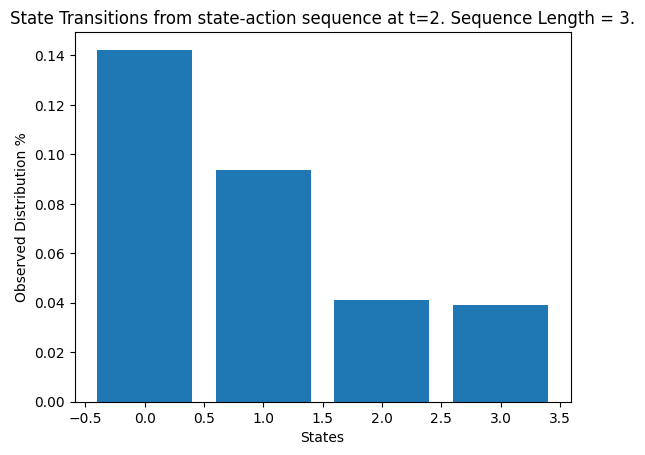

4413

In [58]:
new_state = {}
for i, matrix in enumerate(tqdm(X)):
    if (X[2]==matrix).all():
        if not Y[i,:].tobytes() in new_state:
            new_state[Y[i,:].tobytes()] = 1
        else:
            new_state[Y[i,:].tobytes()] += 1
            
ns = {k: v for k, v in sorted(new_state.items(), key=lambda item: item[1], reverse=True)}

count = 0
for s in ns.keys():
    count += new_state[s]
    print(new_state[s])
    print(np.frombuffer(s))

print(len(new_state.keys()))

values = []
for s in ns.keys():
    values.append(ns[s])
y_pos = np.arange(4)

values = np.array(values) / sum(values)

# Create bars
plt.title('State Transitions from state-action sequence at t=2. Sequence Length = 3.')
plt.xlabel('States')
plt.ylabel('Observed Distribution %')
plt.bar(y_pos, values[:4])
plt.show()
count

696
35
354
0
201
36
188
259
155
202
152
162
144
86
135
143
134
285
107
263
105
38
96
322
93
1
89
251
82
318
79
128
64
319
63
320
61
711
57
142
57
250
48
260
47
913
39
48
35
218
34
767
32
955
31
87
27
327
27
554
25
1188
23
258
22
952
21
903
21
656
20
562
20
257
19
129
19
1457
18
475
18
47
17
1387
17
2
15
524
15
897
15
1139
15
828
14
1251
14
1346
14
9
13
974
13
1407
13
907
12
536
12
780
12
789
12
945
11
203
11
575
11
175
11
348
11
652
11
989
10
139
10
1420
10
120
9
1316
9
363
9
1617
9
1605
8
2196
8
2506
8
888
8
521
8
765
8
37
8
364
8
304
7
476
7
963
7
959
7
1711
6
1054
6
376
6
1310
6
190
6
608
6
1509
6
2341
6
1377
6
100
6
82
6
1482
6
566
6
581
6
1694
6
609
5
1360
5
1805
5
122
5
710
5
1126
5
1180
5
569
5
152
4
171
4
904
4
695
4
1518
4
1424
4
1361
4
405
3
430
3
1342
3
1520
3
1344
3
1679
3
543
3
243
3
1004
3
1097
3
215
3
25
3
2451
3
102
3
273
3
1294
2
3791
2
109
2
2242
2
296
2
5
2
724
2
2239
2
2548
2
121
2
712
2
750
2
1668
2
94
2
1023
2
2456
2
106
2
3912
2
1550
2
1189
2
2303
2
13
2
65
2
77


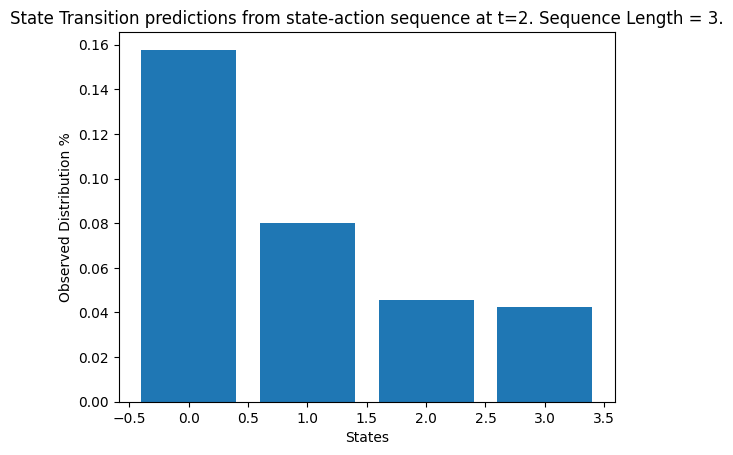

4413

In [72]:
new_state = {}
p = model.predict(np.array([X[2]]))[0]
for i in range(4413):
    s = np.random.choice(np.arange(4285), p=p)
    if not s in new_state:
        new_state[s] = 1
    else:
        new_state[s] += 1
            
ns = {k: v for k, v in sorted(new_state.items(), key=lambda item: item[1], reverse=True)}

count = 0
for s in ns.keys():
    count += new_state[s]
    print(new_state[s])
    print(s)

print(len(new_state.keys()))

values = []
for s in ns.keys():
    values.append(ns[s])
y_pos = np.arange(4)

values = np.array(values) / sum(values)

# Create bars
plt.title('State Transition predictions from state-action sequence at t=2. Sequence Length = 3.')
plt.xlabel('States')
plt.ylabel('Observed Distribution %')
plt.bar(y_pos, values[:4])
plt.show()
count

In [69]:
np.random.choice(np.arange(4285), p=p)

475